In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colorbar
import seaborn as sns
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False

Firstly, we detected gene expression changes induced by uNK cytokines in the organoids. Specifically, for each cell type, we compared the expression level of genes in cells treated with cytokines versus untreated ones. Here we focused on the molecular changes in EVT_late_3 subtype which highly resembled the in vivo iEVT and was most affected by cytokines.

In [2]:
adata = sc.read('../../../scvi_remove_lowUMI/HVG_1000_latent_10_res.h5ad')
adata.obs['CQ'] = adata.obs['celltype'].astype(str) + '_' + adata.obs['activation_status'].astype(str)

lgfd, pval, pct1, pct2  = [], [], [], []
ctys = ['TOM_VCT_proliferating', 'TOM_VCT', 'TOM_SCT', 'VCT', 'SCT',
        'EVT_proliferating', 'EVT_early_1', 'EVT_early_2', 'EVT_early_3',
        'EVT_intermediate_1', 'EVT_intermediate_2',
        'EVT_late_1', 'EVT_late_2', 'EVT_late_3']
ggs = adata.raw.var_names
for cty in ctys:
    gp = cty + '_cytokines'
    rf = cty + '_no_cytokines'
    sc.tl.rank_genes_groups(adata, groupby='CQ', groups=[gp], reference=rf, method='wilcoxon', corr_method='bonferroni', pts=True)
    gg = adata.uns['rank_genes_groups']['names'][gp]
    pj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][gp], index=gg).loc[ggs, 0].values
    lf = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][gp], index=gg).loc[ggs, 0].values
    pts = adata.uns['rank_genes_groups']['pts']
    pt1 = pts.loc[ggs, gp].values
    pt2 = pts.loc[ggs, rf].values
    pval.append(pj)
    lgfd.append(lf)
    pct1.append(pt1)
    pct2.append(pt2)
lgfd = pd.DataFrame(lgfd, columns=ggs, index=ctys).T
pval = pd.DataFrame(pval, columns=ggs, index=ctys).T
pct1 = pd.DataFrame(pct1, columns=ggs, index=ctys).T
pct2 = pd.DataFrame(pct2, columns=ggs, index=ctys).T

##focus on subtype EVT_late_3
de_invitro = pd.DataFrame(dict(padj=pval['EVT_late_3'].values, lgfd=lgfd['EVT_late_3'].values, pct1=pct1['EVT_late_3'].values, pct2=pct2['EVT_late_3'].values), index=pval.index)
idx = ((adata.obs['celltype'] == 'EVT_late_3').values & (adata.obs['activation_status'] == 'cytokines').values)
de_invitro['expr'] = np.log1p(np.expm1(adata.raw.X.A)[idx, :].mean(0))

... storing 'CQ' as categorical


To examine their profiles in vivo between EVT located at the proximal end of the cell column and iEVT, we considered two in vivo datasets (snRNA-seq and scRNA-seq). Specifically, Wilcoxon test was performed between EVT cells located in the cell column (VCT_CCC and EVT_1) and those in deeper decidua (iEVT and GC) (snRNA-seq), as well as between EVT cells collected from placenta and those from decidua (scRNA-seq).

In [3]:
##snRNA-seq in vivo dataset from Arutyunyan et al., Nature 2023
sn_adata = sc.read('../../../adata_P13_trophoblast_raw_counts_in_raw_normlog_counts_in_X_for_download.h5ad')
sn_adata.obs['celltype'] = sn_adata.obs['final_annot_all_troph_corrected'].astype(str)
sn_adata.obs.loc[sn_adata.obs['celltype']=='VCT_CCC', 'celltype'] = 'EVT_1'
sn_adata.obs.loc[sn_adata.obs['celltype']=='GC', 'celltype'] = 'iEVT'
sc.tl.rank_genes_groups(sn_adata, groupby='celltype', groups=['iEVT'], reference='EVT_1', method='wilcoxon', corr_method='bonferroni', pts=True, use_raw=False)
gg = sn_adata.uns['rank_genes_groups']['names']['iEVT']
pj = sn_adata.uns['rank_genes_groups']['pvals_adj']['iEVT']
lf = sn_adata.uns['rank_genes_groups']['logfoldchanges']['iEVT']
pts = sn_adata.uns['rank_genes_groups']['pts']
pt1 = pts.loc[gg, 'iEVT']
pt2 = pts.loc[gg, 'EVT_1']
de_invivo_sn = pd.DataFrame(dict(padj=pj, lgfd=lf, pct1=pt1, pct2=pt2), index=gg)
idx = (sn_adata.obs['celltype']=='iEVT').values
de_invivo_sn['expr'] = np.log1p(np.expm1(sn_adata[idx, gg].X.A).mean(0))

##scRNA-seq in vivo dataset from Vento-Tormo et al., Nature 2018
sc_adata = sc.read('../../../EVT_invitro_invivo_scvi_integration_res.h5ad')
sc_adata = sc_adata.raw.to_adata()
ind = (sc_adata.obs['annotation'] == 'EVT')
sc_adata = sc_adata[ind, :].copy()
sc.tl.rank_genes_groups(sc_adata, groupby='location', groups=['Decidua'], reference='Placenta', method='wilcoxon', corr_method='bonferroni', pts=True)
gg = sc_adata.uns['rank_genes_groups']['names']['Decidua']
pj = sc_adata.uns['rank_genes_groups']['pvals_adj']['Decidua']
lf = sc_adata.uns['rank_genes_groups']['logfoldchanges']['Decidua']
pts = sc_adata.uns['rank_genes_groups']['pts']
pt1 = pts.loc[gg, 'Decidua']
pt2 = pts.loc[gg, 'Placenta']
de_invivo_sc = pd.DataFrame(dict(padj=pj, lgfd=lf, pct1=pt1, pct2=pt2), index=gg)
idx = (sc_adata.obs['location'] == 'Decidua').values
de_invivo_sc['expr'] = np.log1p(np.expm1(sc_adata[idx, gg].X.A).mean(0))

... storing 'celltype' as categorical


The final genes with expression affected by cytokines in the organoids meanwhile showing in vitro-in vivo consistent changes were defined using three criteria: 1) corrected p-value calculated in EVT_late_3 subtype between cells treated with and without cytokines < 0.05; 2) corrected p-value estimated in the first in vivo dataset between EVT cells from cell columns and deep decidua < 0.05; 3) corrected p-value computed in the second in vivo dataset between placental and decidual EVT cells < 0.05; 4) consistent direction of changes across the three comparisons.

In [4]:
##upregulation after cytokine treatment
ind1 = ((de_invitro['padj'] < 0.05).values & (de_invitro['lgfd'] > 0).values)
ind2 = ((de_invivo_sn['padj'] < 0.05).values & (de_invivo_sn['lgfd'] > 0).values)
ind3 = ((de_invivo_sc['padj'] < 0.05).values & (de_invivo_sc['lgfd'] > 0).values)
up_ggs = de_invitro.index[ind1].intersection(de_invivo_sn.index[ind2]).intersection(de_invivo_sc.index[ind3])
print(len(up_ggs))

##downregulation after cytokine treatment
ind1 = ((de_invitro['padj'] < 0.05).values & (de_invitro['lgfd'] < 0).values)
ind2 = ((de_invivo_sn['padj'] < 0.05).values & (de_invivo_sn['lgfd'] < 0).values)
ind3 = ((de_invivo_sc['padj'] < 0.05).values & (de_invivo_sc['lgfd'] < 0).values)
dn_ggs = de_invitro.index[ind1].intersection(de_invivo_sn.index[ind2]).intersection(de_invivo_sc.index[ind3])
print(len(dn_ggs))

aggs = up_ggs.tolist() + dn_ggs.tolist()

44
31


Visualize the changes in expression level of these genes in vitro and in vivo.

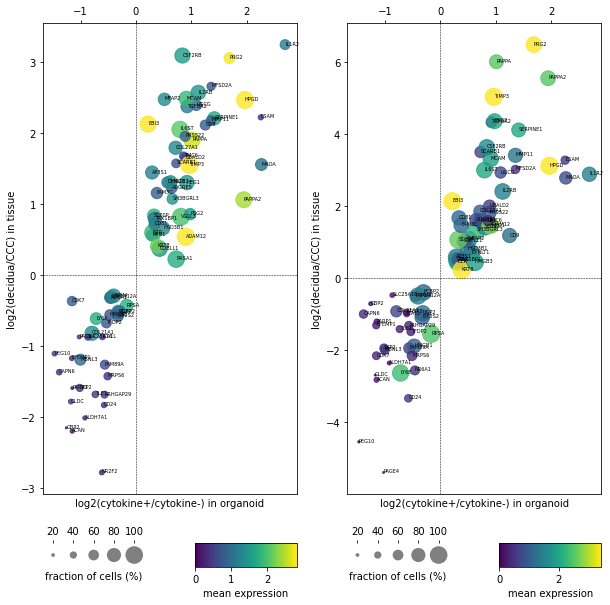

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), gridspec_kw=dict(height_ratios=[1, 0.05]))
for i, de_invivo in enumerate([de_invivo_sn, de_invivo_sc]):
    ax = axs[0, i]
    x = de_invitro.loc[aggs, 'lgfd'].values
    y = de_invivo.loc[aggs, 'lgfd'].values
    ss = (de_invitro.loc[aggs, 'pct1'].values + de_invivo.loc[aggs, 'pct1'].values)/2
    cc = (de_invitro.loc[aggs, 'expr'].values + de_invivo.loc[aggs, 'expr'].values)/2
    vmax = np.percentile(cc, 95)
    ax.scatter(x, y, c=cc, s=(ss**2) * 300, cmap='viridis', vmin=0, vmax=vmax, alpha=0.8)
    for j, gg in enumerate(aggs):
        ax.text(x[j], y[j], gg, size=5)
    ax.set_xlabel('log2(cytokine+/cytokine-) in organoid')
    ax.set_ylabel('log2(decidua/CCC) in tissue')
    ax.axhline(y=0, color='black', linestyle='dashed', linewidth=0.5)
    ax.axvline(x=0, color='black', linestyle='dashed', linewidth=0.5)
    
    laxs = axs[1, i].get_subplotspec().subgridspec(nrows=1, ncols=2, wspace=0.5)
    lax1 = fig.add_subplot(laxs[0, 0])
    lax2 = fig.add_subplot(laxs[0, 1])
    axs[1, i].remove()
    size_range = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
    lax1.set_xlim(0, len(size_range))
    lax1.set_ylim(-0.05, 0.05)
    lax1.set_xlabel('fraction of cells (%)')
    lax1.scatter(np.arange(len(size_range)) + 0.5, np.repeat(0, len(size_range)), s = (size_range**2) * 300, color='gray', edgecolor='black', linewidths=0.1)
    lax1.set_xticks(np.arange(len(size_range)) + 0.5)
    lax1.set_xticklabels([np.round(x * 100).astype(int) for x in size_range])
    lax1.tick_params(axis='y', left=False, labelleft=False)
    for pp in ['right', 'top', 'left', 'bottom']:
        lax1.spines[pp].set_visible(False)
    
    norm = Normalize(vmin=0, vmax=vmax)
    cmap = plt.get_cmap('viridis')
    mappable = ScalarMappable(norm=norm, cmap=cmap)
    matplotlib.colorbar.Colorbar(ax=lax2, mappable=mappable, orientation='horizontal')
    lax2.set_xlabel('mean expression')
plt.show()

Visualize the expression profile of selected genes along the EVT differentiation pathway in vivo and in vitro, as well as in normal and preeclamptic placentas (Tsang et al., 2017 PNAS).

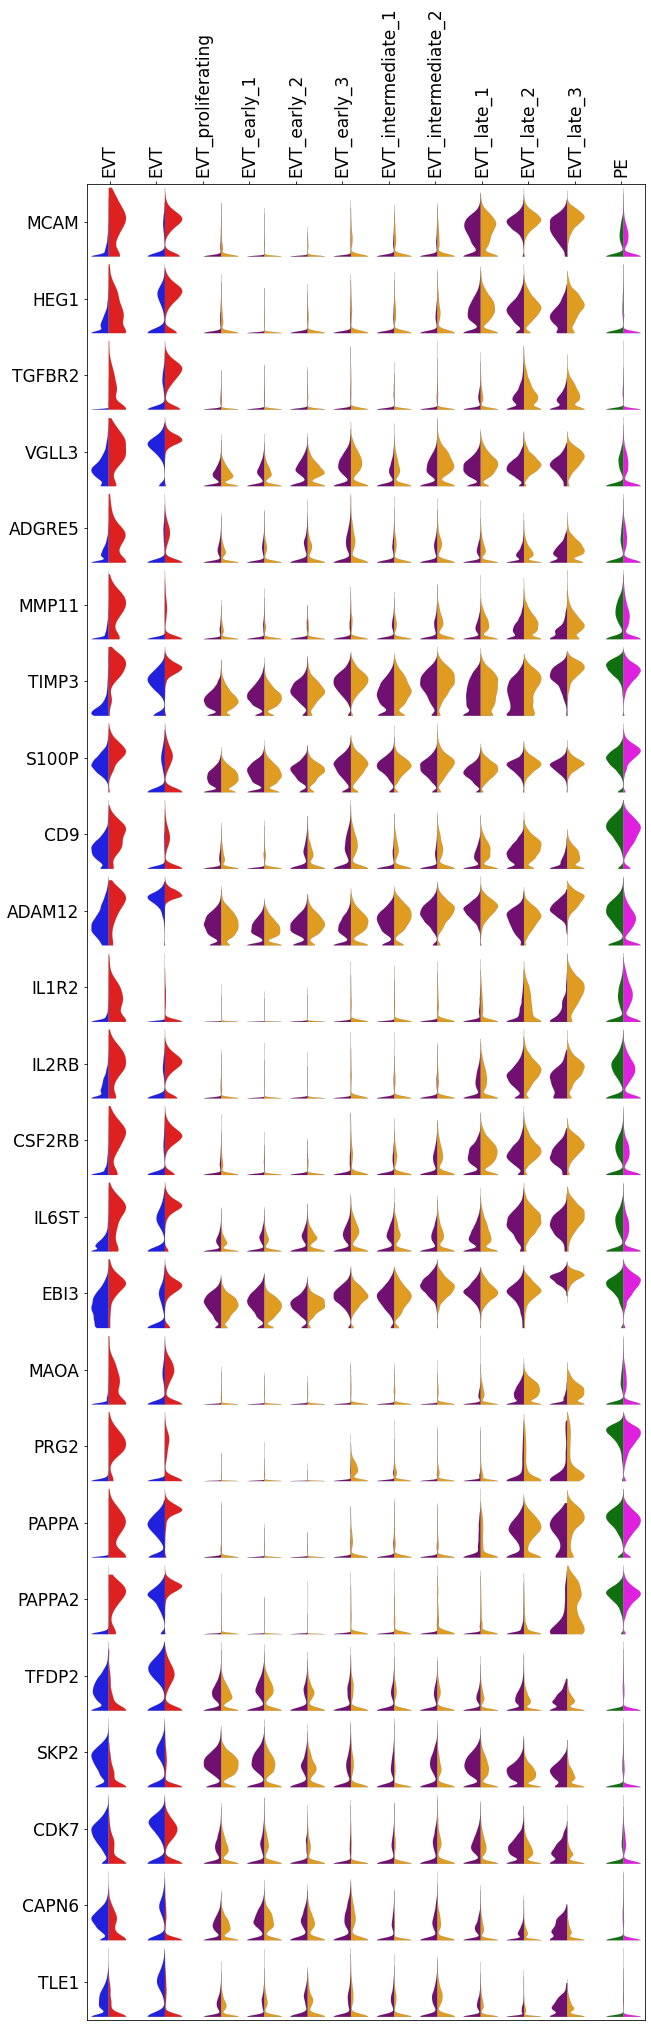

In [6]:
genes = ['MCAM', 'HEG1', 'TGFBR2', 'VGLL3',
         'ADGRE5', 'MMP11', 'TIMP3', 'S100P',
         'CD9', 'ADAM12',
         'IL1R2', 'IL2RB', 'CSF2RB', 'IL6ST', 'EBI3',
         'MAOA', 'PRG2', 'PAPPA', 'PAPPA2',
         'TFDP2', 'SKP2', 'CDK7',
         'CAPN6', 'TLE1',
        ]
cls = ['EVT'] + ['EVT'] + ctys[5:] + ['PE']
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 30), gridspec_kw=dict(top=0.9, bottom=0.05))
ax.set_ylim(0, len(genes))
ax.set_xlim(0, len(cls))
ax.set_xticks(np.arange(len(cls)) + 0.5)
ax.set_xticklabels(cls, rotation=90)
ax.set_yticks(np.arange(len(genes)) + 0.5)
ax.set_yticklabels(genes[::-1])
ax.tick_params(axis='both', labelsize=17)
gs = ax.get_subplotspec().subgridspec(nrows=len(genes), ncols=4, hspace=0.01, wspace=0.1, width_ratios=[1, 1, 9, 1])

##in vivo scRNA-seq
pdata1 = sc_adata.copy()
pdata1.obs['annotation'] = 'EVT'
pdata1.obs['status'] = pdata1.obs['location'].copy()
##in vivo snRNA-seq
idx = sn_adata.obs['celltype'].isin(['EVT_1', 'iEVT'])
pdata2 = sn_adata[idx].copy()
pdata2.obs['annotation'] = 'EVT'
pdata2.obs['status'] = pdata2.obs['celltype'].copy()
##in vitro organoid scRNA-seq
pdata3 = adata.copy()
pdata3 = pdata3.raw.to_adata()
pdata3.obs['annotation'] = pdata3.obs['celltype'].copy()
pdata3.obs['status'] = pdata3.obs['activation_status'].copy()
##preeclamptic scRNA-seq from Tsang et al., 2017 PNAS
pdata4 = sc.read('../../../CSC_revision/preeclampsia_data_Tsang_scvi.h5ad')
pdata4 = pdata4.raw.to_adata()
ggs = pdata4.var_names.values
ggs[ggs == 'CD97'] = 'ADGRE5'
pdata4.var_names = ggs
idx = (pdata4.obs['leiden'] == '1')
pdata4 = pdata4[idx].copy()
pdata4.obs['annotation'] = 'EVT'
pdata4.obs['status'] = pdata4.obs['disease_stat'].copy()

hcls = [['Placenta', 'Decidua'], ['EVT_1', 'iEVT'], ['no_cytokines', 'cytokines'], ['control', 'PE']]
for i, gg in enumerate(genes):
    for j, pdata in enumerate([pdata1, pdata2, pdata3, pdata4]):
        ax = fig.add_subplot(gs[i, j])
        data = pd.DataFrame(dict(gene=pdata[:, gg].X.A[:, 0],
                                 annotation=pdata.obs['annotation'].values,
                                 status=pdata.obs['status'].values))
        rcl = None if j != 2 else cls[2:-1]
        hcl = hcls[j]
        cols = ['blue', 'red'] if j < 2 else ['purple', 'orange'] if j < 3 else ['green', 'magenta']
        sns.violinplot(x='annotation', y='gene', hue='status',
                       hue_order=hcl, data=data,
                       split=True, inner=None, order=rcl, scale='width',
                       linewidth=0.1, cut=0, palette=cols, ax = ax)
        ax.legend_.remove()
        ax.set_axis_off()
plt.show()     